# Determine if an eccentric binary will eclipse

https://ui.adsabs.harvard.edu/abs/2007PASP..119..986B/abstract

http://www.jdso.org/volume13/number2/Harfenist_189-199.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units, constants

%matplotlib inline

In [2]:
def getafromP(m1, m2, P):
    #returns the semimajor axis from the period and stellar masses
    return (((P**2.) * constants.G * (m1 + m2) / (4*np.pi**2.))**(1./3.)).decompose().to(units.AU)

In [3]:
#from our code for circular binaries
def checkEclipse(r1,r2,rp,inclination):
    ratio = (r1 + r2)/rp #rp = 2a for circular orbits
    if (ratio <= 1):
        theta = np.arcsin(ratio)*180./np.pi
        min_incl = 90. - theta
        max_incl = 90. + theta
        if (inclination <= min_incl or inclination >= max_incl):
            return False
    return True

In [4]:
r1 = 1.*units.solRad
r2 = 0.5*units.solRad
per = 100.*units.day
m1 = 1.*units.solMass
m2 = 0.5*units.solMass
semi = getafromP(m1, m2, per)
print(semi)

inclination = 90.


print(checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , 2.*semi.to(units.AU).value, inclination))

0.4826490641022738 AU
True


In [5]:
N = 100
inc = np.linspace(88, 90, N)
testCirc = [checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , 2.*semi.to(units.AU).value, i) for i in inc]
print(testCirc)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


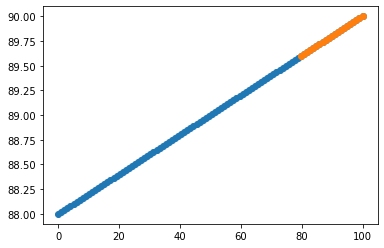

In [6]:
f,ax = plt.subplots()
index = np.linspace(0,N,N)
ax.scatter(index, inc)
ecl = np.where(testCirc)
ax.scatter(index[ecl],inc[ecl])


In [7]:
#try using the python code radvel :https://radvel.readthedocs.io/en/latest/index.html
#https://radvel.readthedocs.io/_/downloads/en/latest/pdf/
import radvel

In [8]:
tp = 100 #time of periastron 
ecc = 0.9 # eccentricity
omega = 0.12345 #argument of peri (radians)

#primary
ttrans = radvel.orbit.timeperi_to_timetrans(np.array([tp]), per.to(units.day).value, ecc, omega)
ta = radvel.orbit.true_anomaly(ttrans, np.array([tp]), per.to(units.day).value, ecc)

rp = semi*(1. - ecc*ecc)/(1. + ecc*np.cos(ta))

print(ttrans,ta, rp, 2.*semi)

#secondary
ttrans = radvel.orbit.timeperi_to_timetrans(np.array([tp]), per.to(units.day).value, ecc, omega, secondary=True)
ta = radvel.orbit.true_anomaly(ttrans, np.array([tp]), per.to(units.day).value, ecc)

rp = semi*(1. - ecc*ecc)/(1. + ecc*np.cos(ta))

print(ttrans,ta, rp, 2.*semi)

[100.78818499] 1.470058867665504 0.08409210783409979 AU 0.9652981282045476 AU
[198.88231953] -1.7016222304054447 0.10390224937653933 AU 0.9652981282045476 AU


In [9]:
radvel.orbit.true_anomaly(np.array([100]), np.array([100]), per.to(units.day).value, ecc)

0.0

In [12]:
N = 100
inc = np.linspace(86, 90, N)
testCirc = []
testEcc = []
for i in inc:
    testCirc.append(checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , 2.*semi.to(units.AU).value, i))
    testEcc.append(checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , rp.to(units.AU).value, i))

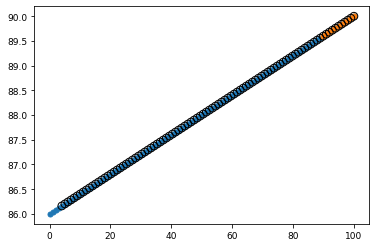

In [13]:
f,ax = plt.subplots()
index = np.linspace(0,N,N)

ax.scatter(index, inc)
ecl = np.where(testCirc)
ax.scatter(index[ecl],inc[ecl])
ecl = np.where(testEcc)

ax.scatter(index[ecl],inc[ecl], facecolors='none', edgecolors='black', s=60)




In [14]:
#verify this with ellc?
#I think I will have to rerun these, but I may not have to rerun everything.  
#  If I take those that weren't observable, then choose a random argument of peri and t0, then check for eclipse
#  and only run those that will eclipse.  Will that work?  But then I will also need to check the observable ones and 
#  limit those somehow... it will be much cleaner to just rerun everything... sigh!

In [15]:
import ellc
import pandas as pd
import numpy as np

from astropy import units as u
from astropy import constants


import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def getafromP(m1, m2, P):
    #returns the semimajor axis from the period and stellar masses
    return (((P**2.) * constants.G * (m1 + m2) / (4*np.pi**2.))**(1./3.)).decompose().to(u.AU)
    
def getRad(logg, m):
    #g = GM/r**2
    g = 10.**logg * u.cm/u.s**2.
    r = ((constants.G*m*u.Msun/g)**0.5).decompose().to(u.Rsun).value
    return r

def getm2(m2Use, mTolUse = 0.001, maxCount = 100):
    counter = 0
    nWarn = 0
    done = False
    
    m2 = 0
    r2 = 0
    
    while (not done) and (counter < maxCount):
        df_sort = model.loc[ (model['Mact'] - m2Use).abs() < mTolUse]
        if (len(df_sort) > 0):
            ss = df_sort.sample()
            m2 = ss['Mact'].iloc[0]
            r2 = getRad(ss['logg'].iloc[0], m2)
            done = True
        else:
            #print('WARNING: increasing tolerance', mTolUse)
            mTolUse *=2
            nWarn += 1
        if (counter > maxCount):
            print('WARNING: did not reach tolerance, will probably die...')
            done = True
        counter += 1
    if (mTolUse > 0.1):
        print(f'WARNING: had to increase mass tolerance {nWarn} times. Max tolerance = {mTolUse}.')
    
    return m2, r2

def checkEclipse(r1,r2,rp,inclination):
    ratio = (r1 + r2)/rp #rp = 2a for circular orbits
    if (ratio <= 1):
        theta = np.arcsin(ratio)*180./np.pi
        min_incl = 90. - theta
        max_incl = 90. + theta
        if (inclination <= min_incl or inclination >= max_incl):
            return False
    return True
    
def checkEccEclipse(r1, r2, a, period, eccentricity, omega, inclination, t_zero):
    
    ttrans = radvel.orbit.timeperi_to_timetrans(np.array([t_zero]), period, eccentricity, omega*np.pi/180.)
    ta = radvel.orbit.true_anomaly(ttrans, np.array([t_zero]), period, eccentricity)

    rp = a*(1. - eccentricity*eccentricity)/(1. + eccentricity*np.cos(ta))
    eclipse_pri = checkEclipse(r1, r2, rp, inclination)

    #secondary
    ttrans = radvel.orbit.timeperi_to_timetrans(np.array([t_zero]), period, eccentricity, omega*np.pi/180., secondary=True)
    ta = radvel.orbit.true_anomaly(ttrans, np.array([t_zero]), period, eccentricity)

    rp = a*(1. - eccentricity*eccentricity)/(1. + eccentricity*np.cos(ta))
    eclipse_sec = checkEclipse(r1, r2, rp, inclination)

    if (not eclipse_pri and not eclipse_sec):
        return False
    return True



In [17]:
model = pd.read_hdf('/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/TRILEGALmodels/TRILEGAL_model_fID_1.h5')
model

,Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,m2/m1,mbol,u_mag,g_mag,r_mag,i_mag,z_mag,Y_mag,Mact
0,1,6.65,0.07,0.47247,-1.462,3.588,4.873,8.9,0.484,0.0,17.326,22.373,19.705,18.398,17.592,17.161,16.939,0.472
1,1,6.65,0.19,0.21215,-2.213,3.533,5.057,11.3,0.572,0.0,21.602,27.880,24.766,23.301,22.117,21.497,21.218,0.212
2,1,6.71,-0.03,2.68100,1.722,4.058,4.321,9.0,0.528,0.0,9.465,11.242,10.449,10.587,10.752,10.848,10.876,2.681
3,1,6.71,0.37,0.19198,-2.166,3.524,4.931,9.0,0.456,0.0,19.184,25.424,22.335,20.899,19.664,19.027,18.743,0.192
4,1,6.77,-0.31,0.16780,-1.847,3.534,4.590,7.0,0.296,0.0,16.387,22.343,19.168,17.718,16.679,16.151,15.912,0.168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442984,3,10.11,-0.03,0.86583,-0.146,3.738,4.420,15.7,0.473,0.0,20.836,23.485,21.819,21.145,20.906,20.791,20.724,0.866
442985,3,10.11,-0.03,0.85323,-0.196,3.733,4.444,16.0,0.578,0.0,21.261,24.142,22.392,21.667,21.400,21.262,21.184,0.853
442986,3,10.11,-0.03,0.52946,-1.265,3.608,4.803,16.2,0.478,0.0,24.133,28.855,26.228,24.950,24.334,23.995,23.806,0.529
442987,3,10.11,-0.03,0.62776,-0.982,3.636,4.708,16.3,0.487,0.0,23.526,27.888,25.339,24.169,23.687,23.425,23.267,0.628


In [18]:
#e = 0.0
#ellc says i~86.06deg
#my code says i~86.07deg

#e = 0.25
#ellc says i~85.26
#my code says i~85.28

#e = 0.5
#ellc says i~83.45deg, 
#my code says i~83.46deg

index = 0

row = model.iloc[index]
m1 = row['Mact']
r1 = getRad(row['logg'], m1)

q = 1.
e = 0.5
p = 5

m2, r2 = getm2(q*m1)

a = getafromP(m1*u.solMass, m2*u.solMass, p*u.day).to(u.solRad).value

inc = 83.45
omega = 30.
t_zero = 0.1*p

f_c = np.sqrt(e)*np.cos(omega*np.pi/180.)
f_s = np.sqrt(e)*np.sin(omega*np.pi/180.)
R_1 = r1/a
R_2 = r2/a

print(m1, m2, r1, r2, p, e, a)
print(checkEccEclipse(r1, r2, a, p, e, omega, inc, t_zero))

0.47200000000000003 0.473 0.41639433559395395 0.41492001413684415 5 0.5 12.07522031028489
True


In [19]:
Ndates = 5000
dates = np.linspace(0, p, Ndates)

In [20]:
lc = ellc.lc(dates, t_zero=t_zero, period=p, a=a, q=q, f_c=f_c, f_s=f_s, 
    radius_1=R_1, radius_2=R_2, incl=inc, sbratio=1.,
    shape_1='sphere', shape_2='sphere', grid_1='default', grid_2='default')

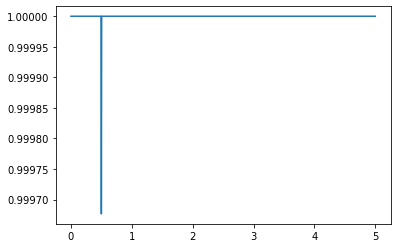

In [21]:
f,ax = plt.subplots()
ax.plot(dates,lc)